## Generating the plot for the stochastic signal that LISA measures considering an observationally motivated population model for the Compact Galactic Binaries model

A script that takes the output of the signal reduction algorithm described in [PRD 104, 043019](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.104.043019), and generates the plot of the data in $h_c$ units.

To make this notebook work we need to install the LDC software which can be found [here](https://lisa-ldc.lal.in2p3.fr/).

Valeriya Korol and NK, 2023

In [254]:
import numpy as np
# For those, the LDC software needs to be installed. It can be found here: https://lisa-ldc.lal.in2p3.fr/
import pickle
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import corner
import ldc.io.hdf5 as h5io
from ldc.lisa.noise import get_noise_model                                                                                                                                                                 

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib import rc  #This does not work for Valeriya on COlab
rc('font',**{'family':'serif','serif':['TX Times']})
rc('text', usetex=True)

%matplotlib inline

In [3]:
with open('/Users/irwin/Documents/GitHub/lisa-ml/data_Model2_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.pkl', 'rb') as filehandle:
    data_1 = pickle.load(filehandle)

There are a couple of keys in that dictionary. Those are the 
* `'f'`: Frequencies of the analysis.
* `'AET'`: The A, E, T channels of the residual galaxy. Basically the FFT of the data
* `'S1'`:  The smoothed residuals plus the instrumental noise.
* `'S1r'`: In some cases we do some extra smoothing on the data. Here we store only the 'raw' running median on the PSD for cross-checking, and in `'S1'` we store the more smoothed data. In most cases though this is the same data repeated because we do not use any extra smoothing.

In [4]:
# Get the catalogue in HDF5 format.
cats, units = h5io.load_array('/Users/irwin/Documents/GitHub/lisa-ml/resolved_Model2_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5', 'cat')
                              #(cat_path + 'resolved_' + cat_name_1 + '.h5', 'cat') #resolved_DWDs_NSWDs_MW_test_tot_pow_NEW.h5'
names_1 = cats['Name']
f0_1    = cats['Frequency'] # Extract the parameters
Amp0_1  = cats['Amplitude']
fdot0_1 = cats['FrequencyDerivative']
snr_1 = np.sqrt(cats['snr2'])
fconf = data_1['f']     # The frequency array of the data
ecc_1 = cats['Eccentricity']

In [5]:
d = (2*5*3e+8*fdot0_1/(96.*np.pi**2.*f0_1**3.*Amp0_1))/3.09e19
Mchirp = ((3e+8**3/6.67e-11)*(5./96.*fdot0_1*np.pi**(-8./3.)*f0_1**(-11./3.))**(3./5.))/1.99e30

In [6]:
len(snr_1)

971

In [7]:
from ldc.common.constants import SPEED_OF_LIGHT, GM_SUN, PARSEC, ASTRONOMICAL_YEAR

# Estimate luminosity distance (in kpc) from GW amplitude, frequency, and frequency derivative
def get_DL(Amp0, f0, fdot):
    return (5/(96*(np.pi**2)))*(SPEED_OF_LIGHT/Amp0)*(fdot)/np.power(f0,3)*(1/(1000*PARSEC))

# Estimate chirp Mass
def get_Mc(f0, fdot):
    return SPEED_OF_LIGHT**3/GM_SUN * ( (5/96) * np.pi**(-8/3) * f0**(-11/3) * fdot)**(3/5)

dL_1    = get_DL(Amp0_1, f0_1, fdot0_1) # Transform to the distances and chirp masses
Mchrp_1 = get_Mc(f0_1, fdot0_1)

In [8]:
# LISA's noise curve 
Tobs     = 4*ASTRONOMICAL_YEAR                # Duration of the measurement
f        = np.linspace(1e-4,1e-1,1000)        # The frequency array

lisa_noise = get_noise_model('SciRDv1', f)

In [9]:
# Define the sky-averaged response function
def response_AE(f):
    """
    The sky averaged LISA response function for the A and E TDI channels.
    """
    lisaLT = lisa_noise.arm_length/SPEED_OF_LIGHT
    x = 2.0 * np.pi * lisaLT * f 
    return np.absolute(9/20 /(1 + (3 *x/4)**2 ) * ((16 * x**2 * np.sin(x)**2))) / 2

In [10]:
def compute_hGB(Mchrp, f0, dL):
    """
    Compute the point signals of the recovered binaries. 
    Taken from arXiv:1803.01944 (see eq. (27) )
    
    Mchirp - The chirp mass
    f0     - Source frequency
    dL     - The distance
    
    """
    nom   = 8*np.sqrt(Tobs)*(GM_SUN*Mchrp/SPEED_OF_LIGHT**3)**(5/3) * np.pi**(2/3) * f0**(2/3) 
    denom = np.sqrt(5) * dL * (1000*PARSEC) / SPEED_OF_LIGHT
    return nom/denom

# Compute the strain amplitude of the resolved sources in order to verify the 
# computation of the dots in the plot. Uncomment lines in the next cell in order
# to actuall plot those data.
resolved_sources_1 = compute_hGB(Mchrp_1, f0_1, dL_1)

In [11]:
# Compute the sensitivity
lisasens = lisa_noise.sensitivity()

Compute the PSD of the residuals, becasue in `'S1'` it's the GB confusion plust hte instrumental noise

In [12]:
df = np.abs(fconf[1]-fconf[0]) # Get the freq. resolution

# Compute the PSD
conf_psd_1 = 2 * df * np.absolute(data_1['AET']['A'])**2 

from scipy import ndimage

# Do the running median on the PSD, normalize with a constant to account for bias of mean vs median
conf_psd_smoothed_1 = ndimage.median_filter(conf_psd_1, size=2000) / 0.7023319615912207

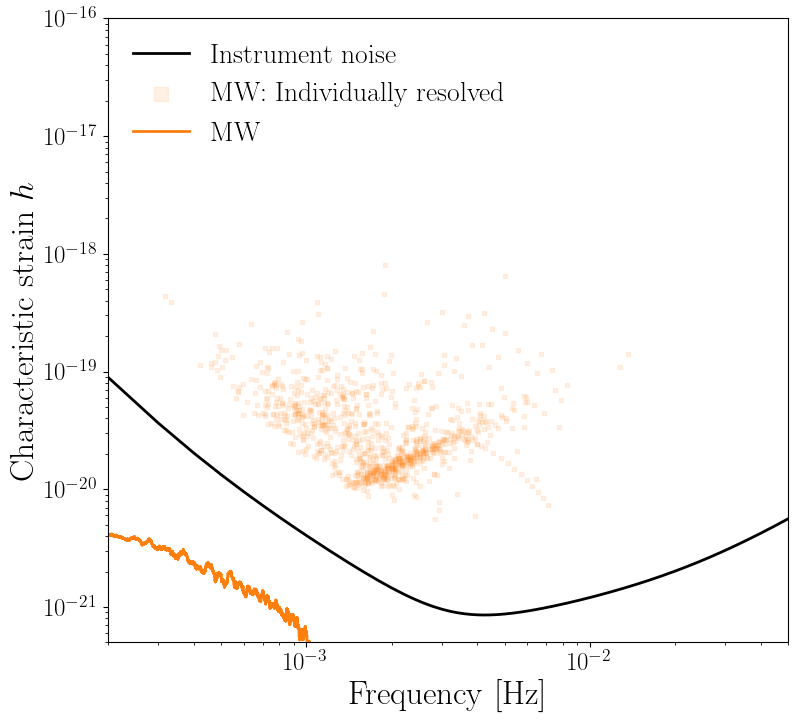

In [13]:
fig, ax1 = plt.subplots(figsize=(8,8)) 
plt.subplots_adjust(left=0.13, right=0.98, top=0.9, bottom=0.12)

### Sensitivity
plt.loglog(f, np.sqrt( f * lisasens/2), 'k-', linewidth=2, label='Instrument noise')
# plt.loglog(f, np.sqrt( f * conf_default_plusnoise/2), lw=2, label='Default BPS unresolved foreground plus instrument noise', linestyle='--', color='gray', alpha=.5) 

### New foreground signal: Individually detected 
plt.scatter(f0_1, np.sqrt(16/5) * np.sqrt(Tobs*f0_1) * Amp0_1, s=10, marker='s', edgecolor=None, color='C1', alpha=.1, label='MW: Individually resolved')
#plt.scatter(f0_2, np.sqrt(16/5) * np.sqrt(Tobs*f0_2) * Amp0_2, s=10, edgecolor=None, color='mediumseagreen', alpha=.1, label='MW + NSWDs: Individually resolved')

# This is where I plot the eq. (26) from arXiv:1803.01944, and it overlaps with the one above.
# I need a factor of two, which comes from the fact that in the paper above they are using a 
# sensitivity a factor of 2 lower than what is implemented for the LDC. In LDC they use the 
# S_{h,X}, which is based on the X channel, while if we use the combined sinsitivity we have
# to divide by 2. This is explained above eq. (43) in arXiv:2108.01167. Thus, I will use the
# definitions of arXiv:1803.01944, while dividing all other quantities by a factor of 2.
# 
# plt.scatter(f0, np.sqrt(f0)/2 * resolved_sources, s=10, edgecolor=None, color='crimson', alpha=0.3, label='Individually resolved (eq. 27) of arXiv:1803.01944')

### Foreground
plt.loglog(fconf, np.sqrt(conf_psd_smoothed_1*fconf/response_AE(fconf)/2), 'C1-', lw=2, label='MW')
#plt.loglog(fconf, np.sqrt(conf_psd_smoothed_2*fconf/response_AE(fconf)/2), 'mediumseagreen', lw=2, label='MW + NSWDs')

### Plot settings
plt.xlabel(r'Frequency [Hz]', fontsize=24)
plt.ylabel(r'Characteristic strain $h$', fontsize = 24)
plt.ylim([5e-22,1e-16])
plt.xlim([2e-4,5e-2])

plt.yscale('log')
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=18) 
plt.legend(fontsize=20, frameon=False, loc='upper left', markerscale=3.)
#plt.savefig('Characteristic_strain_plot.pdf')
plt.show()

In [ ]:
with open('fims_Model2_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.pkl', 'rb') as filehandle:
    data_fim = pickle.load(filehandle)

## Reproducing Fig 3. LEGWORK

In [55]:
import legwork.visualisation as vis
from legwork import source, psd
import astropy.units as u
import legwork as lw
import matplotlib.pyplot as plt

In [99]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [131]:
# set eccentricities
ecc = np.array([1e-6, 0.1,0.2,0.4,0.5, 0.6, 0.9])
n_binaries = len(ecc)

# use constant values for mass, f_orb and distance
m_1 = np.repeat(0.6, n_binaries) * u.Msun
m_2 = np.repeat(0.6, n_binaries) * u.Msun
f_orb = np.repeat(1.5e-3, n_binaries) * u.Hz
dist = np.repeat(15, n_binaries) * u.kpc
# get the SNR in each harmonic
snr2_n = lw.snr.snr_ecc_evolving(m_1=m_1, m_2=m_2, f_orb_i=f_orb, ecc=ecc, dist=dist,
                                 harmonics_required=100, t_obs=4 * u.yr, n_step=1000,
                                 ret_snr2_by_harmonic=True)

snr = snr2_n.sum(axis=1)**(0.5)

In [132]:
print(snr)

[31.83881026 32.59797207 34.74880781 41.89993689 46.1455579  50.31022837
 38.94696211]


In [133]:
print(snr2_n.shape)

(7, 100)


findfont: Generic family 'serif' not found because none of the following families were found: TX Times
findfont: Generic family 'serif' not found because none of the following families were found: TX Times
findfont: Generic family 'serif' not found because none of the following families were found: TX Times
findfont: Generic family 'serif' not found because none of the following families were found: TX Times
findfont: Generic family 'serif' not found because none of the following families were found: TX Times
findfont: Generic family 'serif' not found because none of the following families were found: TX Times
findfont: Generic family 'serif' not found because none of the following families were found: TX Times
findfont: Generic family 'serif' not found because none of the following families were found: TX Times
findfont: Generic family 'serif' not found because none of the following families were found: TX Times
findfont: Generic family 'serif' not found because none of the following 

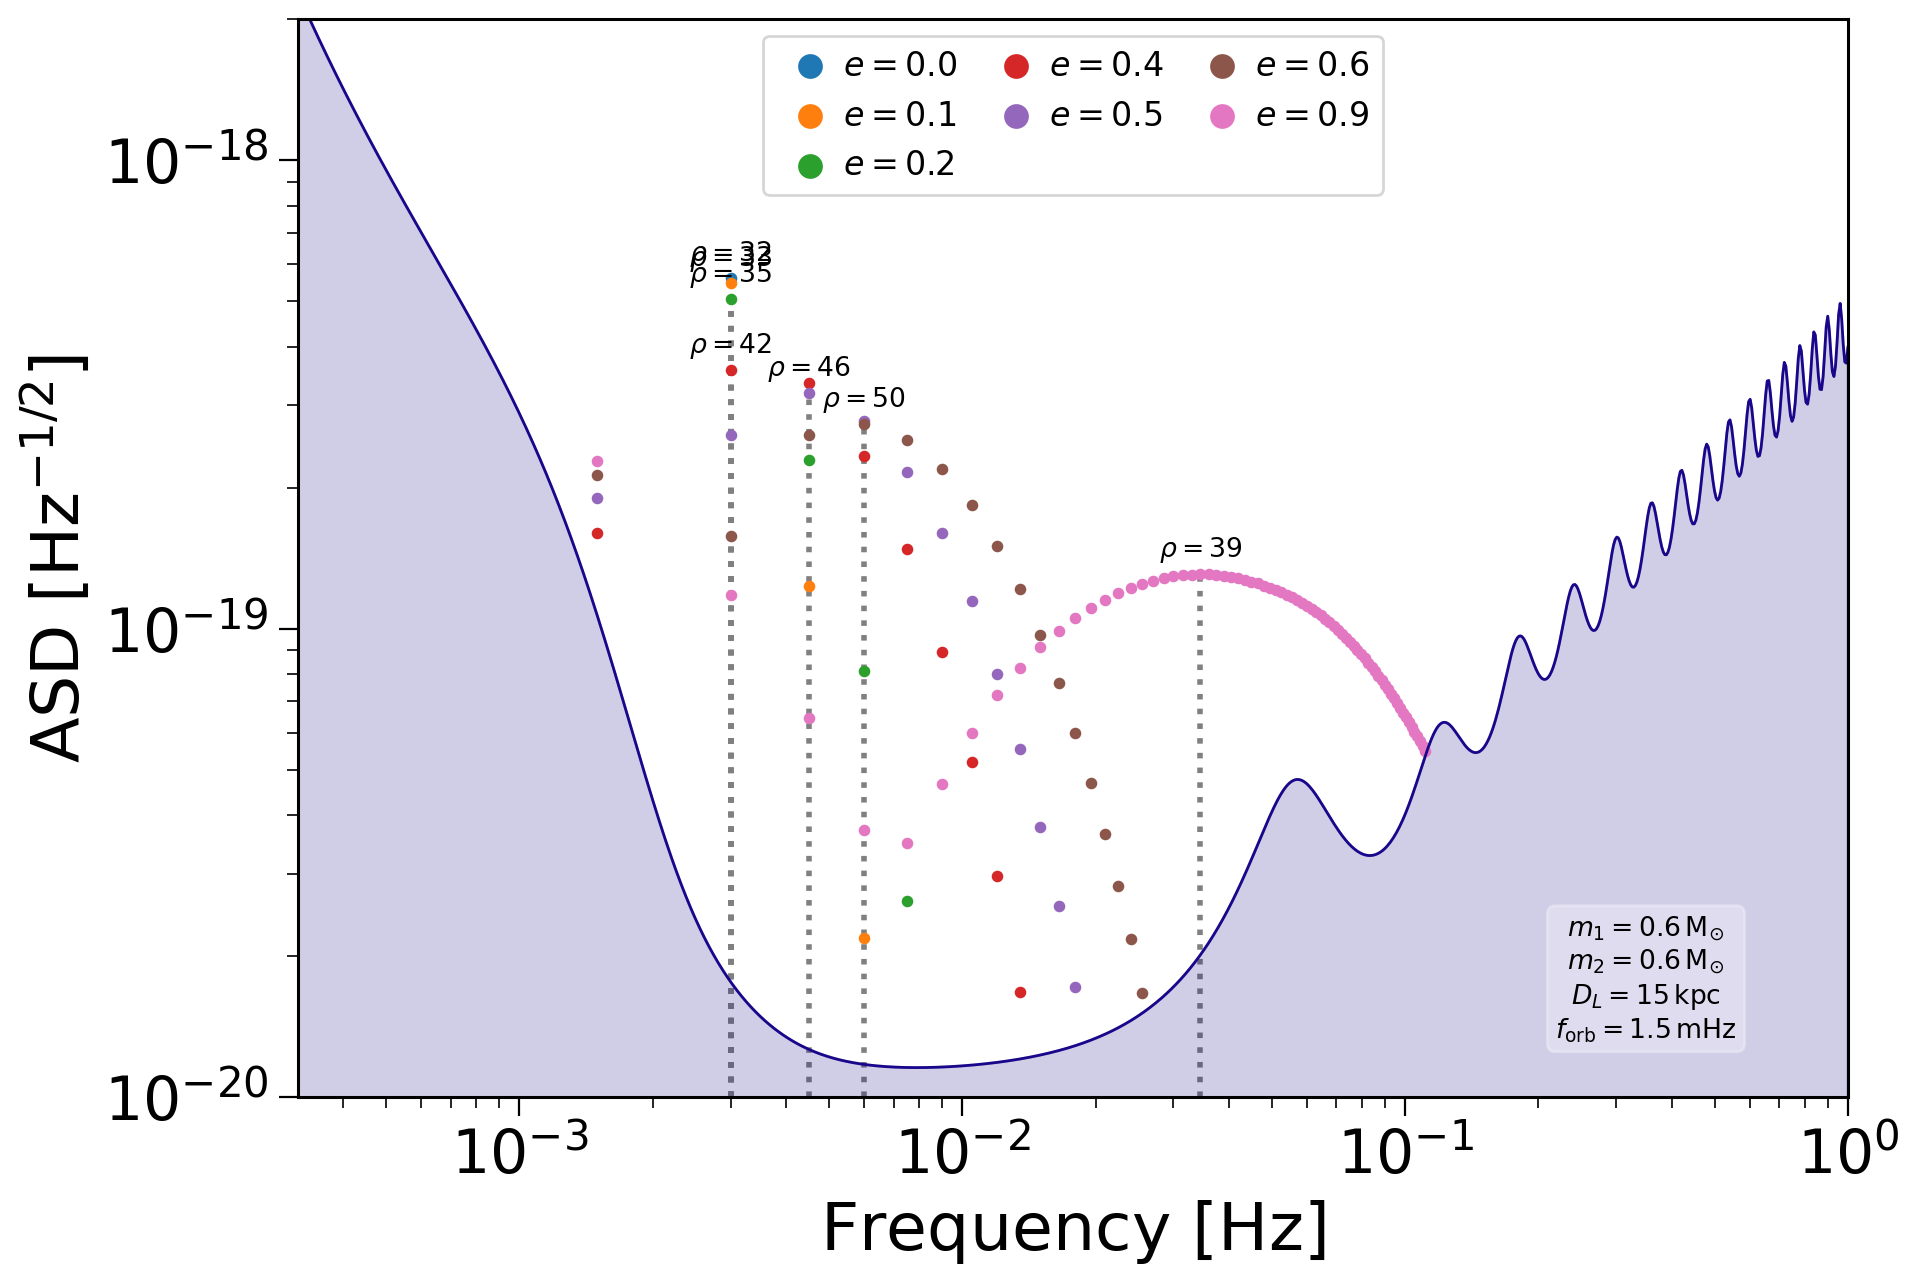

In [134]:
# plot LISA sensitivity curve
fig, ax = lw.visualisation.plot_sensitivity_curve(frequency_range=np.logspace(-3.5, 0, 1000) * u.Hz,
                                                  show=False)

# plot each sources
#colours = [plt.get_cmap("plasma")(i) for i in [0.1, 0.5,0.6,0.7, 0.8,0.9]]
for i in range(len(snr2_n)):
    # work out the harmonic frequencies and ASDs
    f_harm = f_orb[i] * range(1, len(snr2_n[0]) + 1)
    y_vals = lw.psd.lisa_psd(f_harm)**(0.5) * np.sqrt(snr2_n)[i]

    # only plot points above the sensitivity curve
    mask = np.sqrt(snr2_n)[i] > 1.0

    # compute the index of the maximal SNR value
    max_index = np.argmax(y_vals[1:]) + 1

    # plot each harmonic
    ax.scatter(f_harm[mask], y_vals[mask],
               s=10,
               label=r"$e={{{:1.1f}}}$".format(ecc[i]))

    # annotate each source with its SNR at the max SNR value
    ax.annotate(r"$\rho={{{:1.0f}}}$".format(snr2_n[i].sum()**(0.5)),
                xy=(f_harm[max_index].value, y_vals[max_index].value * 1.05),
                ha="center", va="bottom", fontsize=0.4*fs)
    # plot a dotted line to highlight where the signal is concentrated
    ax.plot([f_harm[max_index].value] * 2, [1e-20, y_vals[max_index].value],
               color="grey", linestyle="dotted", lw=2, zorder=0)

# add a legend and annotate the other source properties
ax.legend(markerscale=2.5, handletextpad=0.0, ncol=3, loc="upper center",
          columnspacing=0.75, fontsize=0.5 * fs)

annotation_string = r"$m_1 = 0.6 \, {\rm M_{\odot}}$"
annotation_string += "\n"
annotation_string += r"$m_2 = 0.6 \, {\rm M_{\odot}}$"
annotation_string += "\n"
annotation_string += r"$D_L = 15 \, {\rm kpc}$"
annotation_string += "\n"
annotation_string += r"$f_{\rm orb} = 1.5 \, {\rm mHz}$"

ax.annotate(annotation_string, xy=(3.5e-1, 1.3e-20), ha="center", va="bottom", fontsize=0.4 * fs,
            bbox=dict(boxstyle="round", fc="white", ec="white", alpha=0.3))

ax.set_ylim(1e-20, 2e-18)

plt.show()

## For a given Strain and Freq, plot the harmonics of the binary

In [136]:
import legwork.strain as strain

In [179]:
#Calculate characteristic strain
m_1 = np.linspace(0.6,1.0, 50) * u.Msun
m_2 = np.linspace(0.6,1.0,50) *u.Msun
f_orb = np.linspace(1e-3, 1e-2, 50) * u.Hz
dist = np.repeat(15, 50) * u.kpc
ecc = np.linspace(1e-6, 0.99, 50)
mc = lw.utils.chirp_mass(m_1,m_2)
n= np.arange(1,101,1)

In [180]:
snr2_n = lw.snr.snr_ecc_evolving(m_1=m_1, m_2=m_2, f_orb_i=f_orb, ecc=ecc, dist=dist,
                                 harmonics_required=100, t_obs=4 * u.yr, n_step=1000,
                                 ret_snr2_by_harmonic=True)

snr = snr2_n.sum(axis=1)**(0.5) 

/var/folders/rm/5j_dp79x6xx6xmxlxxs9k4y80000gn/T/ipykernel_90347/871291279.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap("plasma")


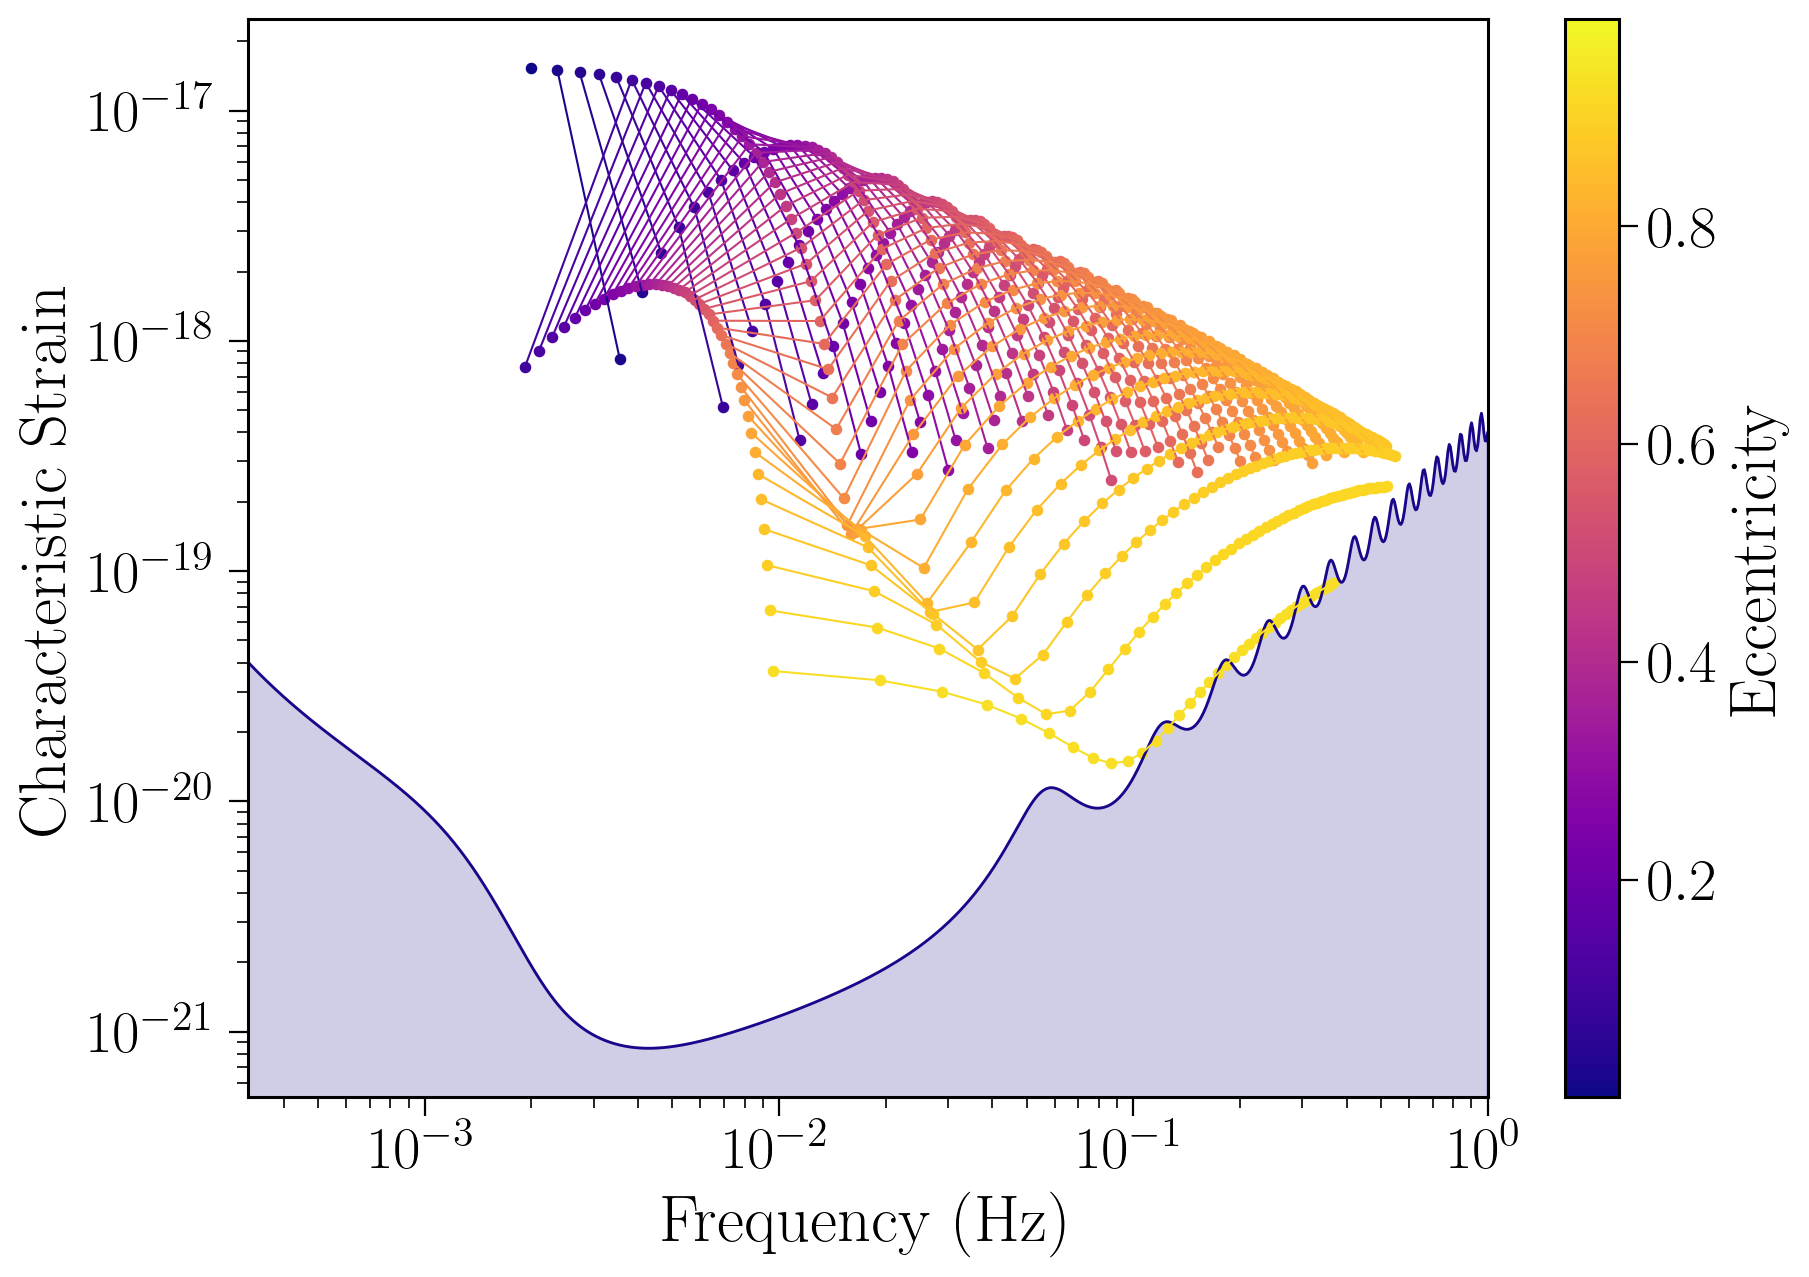

In [193]:
fig, ax = lw.visualisation.plot_sensitivity_curve(frequency_range=np.logspace(-3.5, 0, 1000) * u.Hz,
                                                  show=False, y_quantity='h_c')
h_c_2 = strain.h_c_n(m_c = mc, f_orb = f_orb, ecc=ecc, dist = dist, n = n)
h_c_2 = h_c_2.reshape(50,100)
# Set up a color map and assign a unique color to each binary
colormap = get_cmap("plasma")
norm = Normalize(vmin=min(ecc), vmax=max(ecc))
#colors = [colormap(i / len(snr2_n)) for i in range(len(snr2_n))]
scalar_map = ScalarMappable(norm=norm, cmap=colormap)
# Loop over each binary and plot its harmonics with consistent color
for i in range(len(snr2_n)):
    # Calculate harmonic frequencies
    f_harm = f_orb[i] * np.arange(1, len(snr2_n[0]) + 1)

    # Mask to plot only points above the sensitivity curve
    mask = np.sqrt(snr2_n[i]) > 1.0
    color = scalar_map.to_rgba(ecc[i])

    ax.scatter(f_harm[mask], h_c_2[i][mask], s=10, color=colors[i],
               label=f"Binary {i + 1}")
    ax.plot(f_harm[mask], h_c_2[i][mask], color=colors[i], linewidth=0.75)

#ax.legend(title="Binaries", loc="upper right", fontsize=8, markerscale=1.5)
cbar = plt.colorbar(scalar_map, ax=ax)
cbar.set_label("Eccentricity")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
#plt.title("Harmonic Contributions for Each Binary at Fixed Eccentricity")
plt.show()

## For different initial conditions, how long does it take for binary to circularized. 

/Users/irwin/opt/anaconda3/envs/legwork/lib/python3.11/site-packages/legwork/evol.py:401: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  ecc_evol = np.array([odeint(de_dt, ecc_i[i], timesteps[i], args=(beta[i], c_0[i])).flatten()
/Users/irwin/opt/anaconda3/envs/legwork/lib/python3.11/site-packages/legwork/utils.py:225: RuntimeWarning: invalid value encountered in power
  a = c_0 * ecc**(12/19) / (1 - ecc**2) * (1 + (121/304) * ecc**2)**(870/2299)
/Users/irwin/opt/anaconda3/envs/legwork/lib/python3.11/site-packages/legwork/utils.py:225: RuntimeWarning: overflow encountered in square
  a = c_0 * ecc**(12/19) / (1 - ecc**2) * (1 + (121/304) * ecc**2)**(870/2299)
/Users/irwin/opt/anaconda3/envs/legwork/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/irwin/opt/anaconda3/e

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3721842029702D+12   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9286223580092D+12   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2623637265386D+12   r2 =  0.5668401107281D-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2623637265386D+12   r2 =  0.5668401107281D-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue

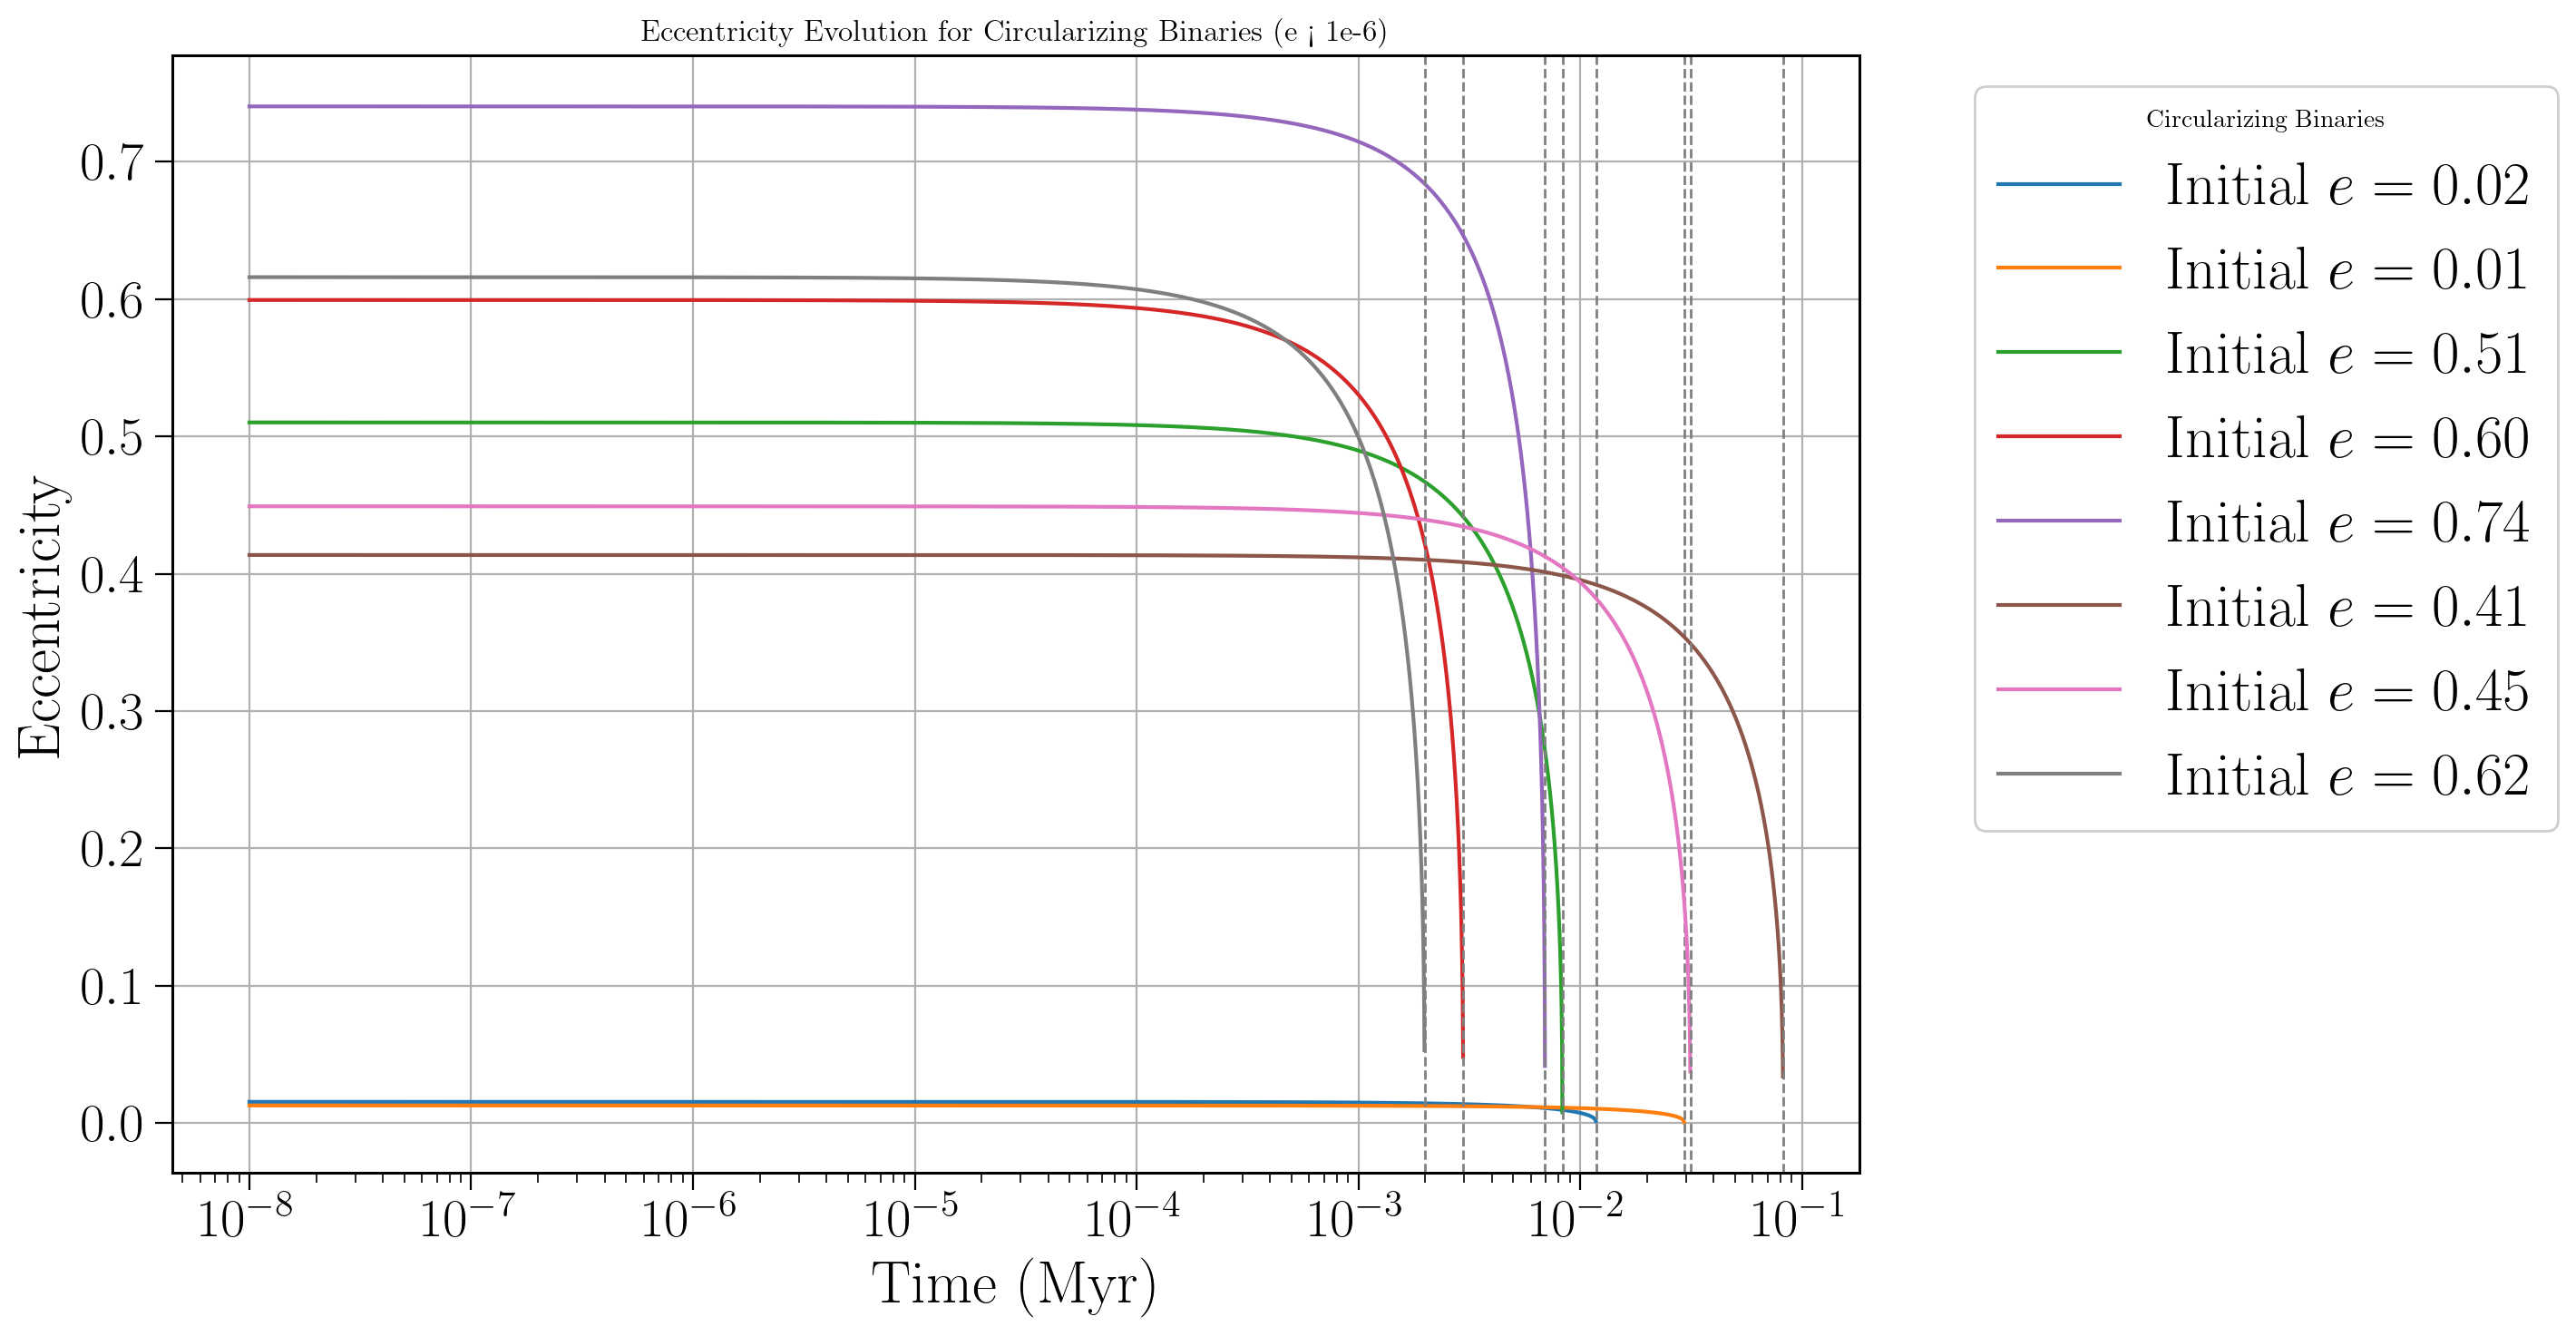

In [244]:
n_binaries = 20
m_1 = np.repeat(15, n_binaries) * u.Msun
m_2 = np.repeat(15, n_binaries) * u.Msun
f_orb_i = 10**(np.random.uniform(-6, -3, n_binaries)) * u.Hz
ecc_i = np.random.uniform(0, 0.9, n_binaries)

timesteps = (np.logspace(-2, 5, 10000) * u.yr).to(u.Myr)

# Calculate eccentricity evolution
ecc_evol, _ = lw.evol.evol_ecc(
    ecc_i=ecc_i, m_1=m_1, m_2=m_2, f_orb_i=f_orb_i,
    timesteps=timesteps, t_before=10 * u.yr, avoid_merger=False
)

# Define a threshold to consider circularization (near-zero eccentricity)
ecc_threshold = 1e-6
circularization_times = []

# Filter only circularizing binaries and record their circularization times
for i in range(n_binaries):
    if np.any(ecc_evol[i] < ecc_threshold):  # Check if binary circularizes
        threshold_index = np.where(ecc_evol[i] < ecc_threshold)[0][0]
        time_to_circularize = timesteps[threshold_index]
        circularization_times.append((i, threshold_index, time_to_circularize))  # Store index, threshold index, and time

# Plot eccentricity evolution for only the circularizing binaries
fig, ax = plt.subplots()

for i, threshold_index, circ_time in circularization_times:
    # Plot up to just before reaching the threshold
    ax.plot(
        timesteps[:threshold_index].value, ecc_evol[i][:threshold_index], lw=1.5,
        label=f"Initial $e={ecc_i[i]:.2f}$"
    )
    # Add a vertical line indicating the circularization time
    ax.axvline(circ_time.value, color='gray', linestyle='--', lw=1)

# Set plot labels and log scale for better visualization
ax.set_xlabel("Time (Myr)")
ax.set_ylabel("Eccentricity")
#ax.set_yscale("log")
ax.set_xscale('log')
ax.legend(title="Circularizing Binaries", loc="upper left", bbox_to_anchor=(1.05, 1), framealpha=0.95)
plt.title("Eccentricity Evolution for Circularizing Binaries (e < 1e-6)")
plt.grid(True)
plt.show()

## Corner plot

In [267]:
with open('/Users/irwin/Documents/GitHub/lisa-ml/fims_Model2_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.pkl', 'rb') as filehandle:
    data = pickle.load(filehandle)

In [268]:
data['parameter names']

['Frequency_mHz',
 'FrequencyDerivative_log10',
 'EclipticLatitude_sin',
 'EclipticLongitude',
 'Amplitude_log10',
 'Inclination_cos',
 'Polarization',
 'InitialPhase']

In [269]:
data['MW_DWD 0'].shape

(8, 8)

In [279]:
# Define parameter names
parameter_names = [
    'Frequency_mHz',
    'FrequencyDerivative_log10',
    'EclipticLatitude_sin',
    'EclipticLongitude',
    'Amplitude_log10',
    'Inclination_cos',
    'Polarization',
    'InitialPhase'
]

covariance_matrix = np.linalg.inv(data['MW_DWD 0'])

sigma_values = np.sqrt(np.diag(covariance_matrix))
samples = np.random.multivariate_normal(np.zeros(8), covariance_matrix, size=100000)


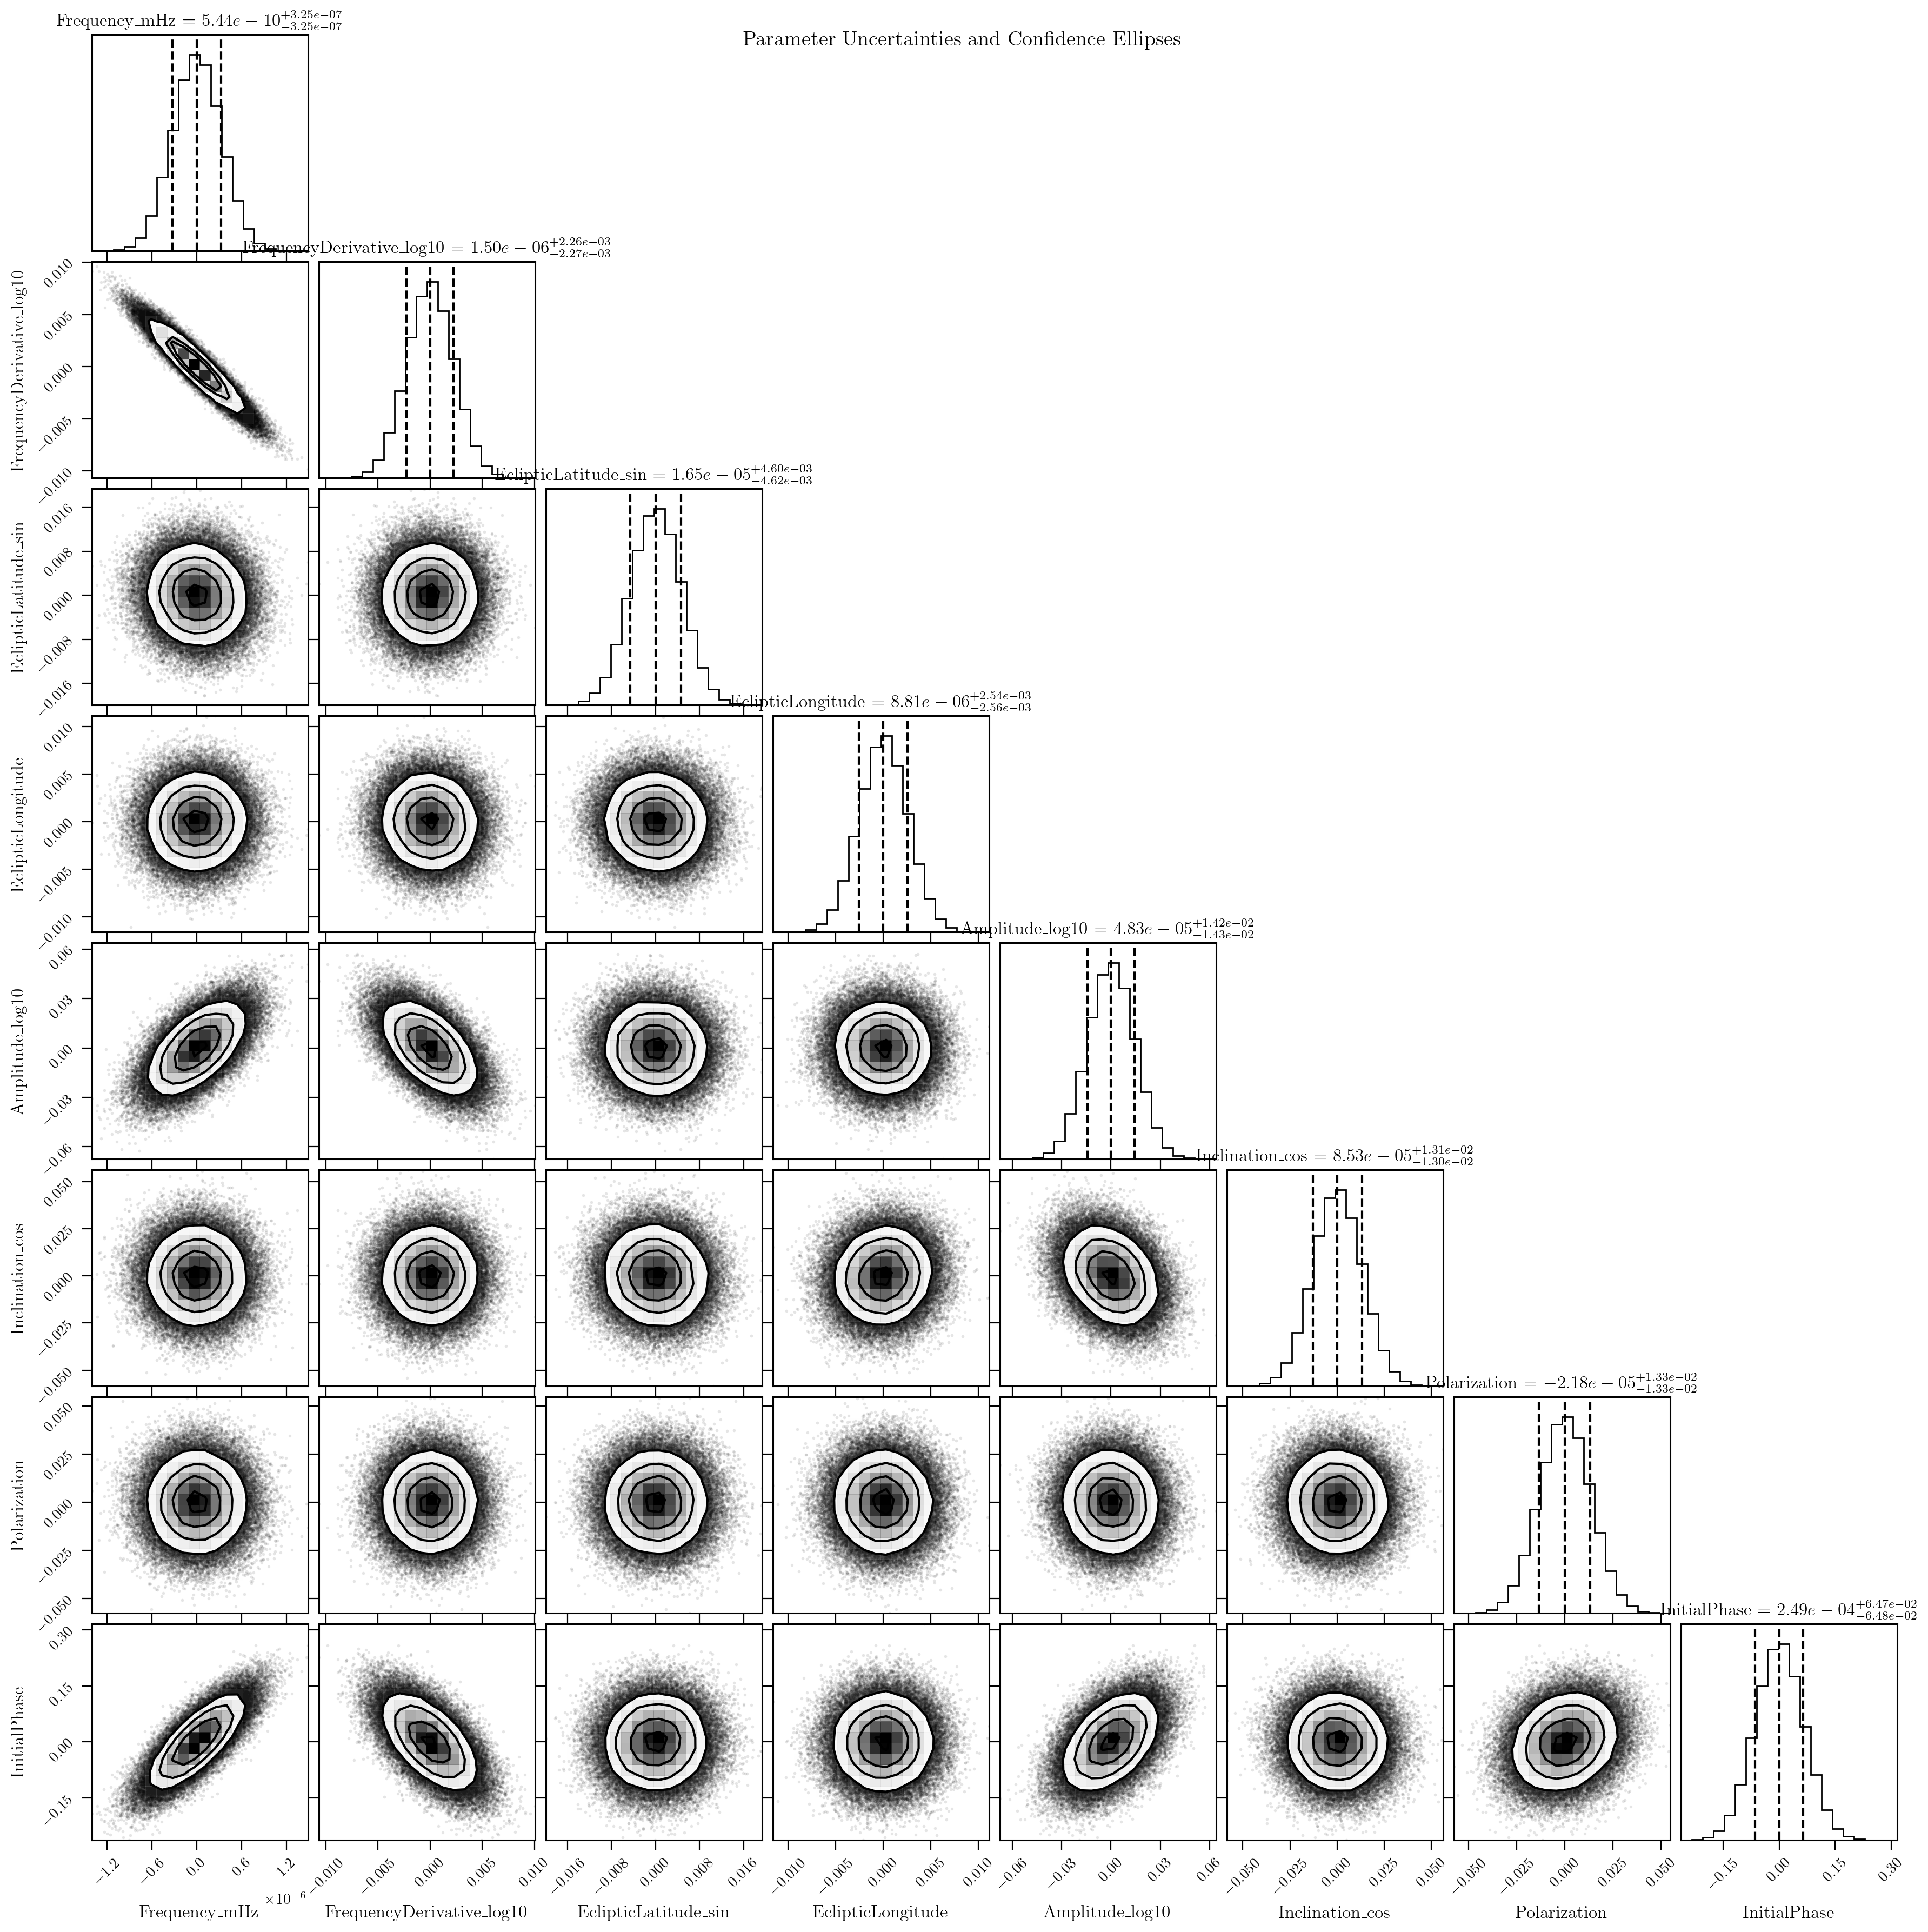

In [280]:
fig = corner.corner(
    samples,
    labels=parameter_names,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt=".2e",
    label_kwargs={"fontsize": 12},
)
for ax in fig.get_axes():
    plt.setp(ax.get_xticklabels(), fontsize=10)  
    plt.setp(ax.get_yticklabels(), fontsize=10) 
    
for ax in fig.get_axes():
    ax.xaxis.get_offset_text().set_fontsize(10)
    ax.yaxis.get_offset_text().set_fontsize(10)
plt.suptitle("Parameter Uncertainties and Confidence Ellipses", fontsize=14)
plt.show()